In [3]:
import numpy as np
import scipy.sparse as sp
from fredapi import Fred
from collections import OrderedDict
import matplotlib.pyplot as plt

In [157]:
#upwind step for value function; If, Ib, I0 do not conflict
def upwind_value_function(dVf, dVb, dV0, sf, sb):
    If = sf > 0 #positive drift
    Ib = sb < 0 #negative drift
    I0 = (1 - If - Ib)
    V = dVf * If + dVb * Ib + dV0 * I0
    return V, If, Ib, I0

#known form of value function but unsure if If, Ib, I0 uniquely ID
def upwind_value_function_unsure(Vaf, Vab, Va0, Vf_orig, Vb_orig, V0_orig, cf, cb, c0, sf, sb, reverse_sign):
    Vf = (cf > 0) * (Vf_orig + sf * Vaf) + (cf <= 0) * reverse_sign
    Vb = (cb > 0) * (Vb_orig + sb * Vab) + (cb <= 0) * reverse_sign
    V0 = (c0 > 0) * V0_orig + (c0 <= 0) * reverse_sign
    I_neither = (1 - (sf > 0)) * (1-(sb<0)) #zero drift
    I_unique = (sb <0) * (1-(sf >0)) + (1-(sb <0)) * (sf >0) #one direction drift
    I_both = (sb <0) * (sf >0) #both direction drift
    #label indices
    Ib = I_unique * (sb<0)*(Vb>V0) + I_both*(Vb == np.maximum(np.maximum(Vb,Vf),V0))
    If = I_unique * (sf>0)*(Vb>V0) + I_both*(Vb == np.maximum(np.maximum(Vb,Vf),V0))
    I0 = I_neither + (1-I_neither)*(V0 == np.maximum(np.maximum(Vb,Vf),V0))
    I0 = 1 - Ib - If
    V = Vaf * If + Vab * Ib + Va0 * I0
    return V, If, Ib, I0

def upwind_matrix(A_switch, sf, sb, f_diff, b_diff, wealth_dim, other_dims, exact=True, If=np.zeros((0, 0)), Ib=np.zeros((0, 0)), I0=np.zeros((0, 0))):
    #throw errors
    if len(sf) != wealth_dim:
        raise Exception("wealth_dim is wrong")
    elif f_diff.size != sf.size or b_diff.size != sf.size:
        raise Exception("diff dimension along wealth dim is wrong")

    #compute diagonals of first order diff V
    if exact: #sf or sb exactly zero
        X = -np.minimum(sb,0)/b_diff
        Y = -np.maximum(sf,0)/f_diff+np.minimum(sb,0)/b_diff
        Z = np.maximum(sf,0)/f_diff
    else:
        X = -Ib * sb / b_diff
        Y = -If * sf / f_diff + Ib * sb/b_diff
        Z = If * sf / f_diff

    total_dims = wealth_dim * other_dims
    centdiag = Y.flatten()
    updiag = np.zeros(R, total_dims - 1)
    lowdiag = np.zeros(R, total_dims - 1)
    for i in range(other_dims):
        for j in range(wealth_dim):
            if j < wealth_dim - 1: #come back to for indexing
                updiag[wealth_dim * i + j] = Z[j,i]
                lowdiag[wealth_dim * i + j] = X[j + 1, i]

    AA = sp.diags([lowdiag, centdiag, updiag], offsets=[-1, 0, 1], shape=(total_dims, total_dims))
    A = AA + A_switch
    return A

#fix below
#same as above but now forward/backward diff the same
def upwind_matrix_same_diff(A_switch, sf, sb, diff, wealth_dim, other_dims, exact=True, If=None, Ib=None, I0=None):
    if len(sf) != wealth_dim:
        raise Exception("wealth_dim is wrong")

    #compute diagonals of first order diff V
    if exact: #sf or sb exactly zero
        X = -np.minimum(sb,0)/diff
        Y = -np.maximum(sf,0)/diff+np.minimum(sb,0)/diff
        Z = np.maximum(sf,0)/diff
    else:
        X = -Ib * sb / diff
        Y = -If * sf / diff + Ib * sb/diff
        Z = If * sf / diff

    total_dims = wealth_dim * other_dims
    centdiag = Y.flatten()
    updiag = np.zeros(total_dims - 1)
    lowdiag = np.zeros(total_dims - 1)

    for j in range(other_dims):
        for i in range(wealth_dim):
            if i < wealth_dim - 1:
                updiag[wealth_dim * j + i] = Z[i, j]
                lowdiag[wealth_dim * j + i] = X[i + 1, j]

    AA = sp.diags([lowdiag, centdiag, updiag], offsets=[-1, 0, 1], shape=(total_dims, total_dims))
    A = AA + A_switch
    return A

#uses sp.linalg.spsolve, the equivalent of Julia's left divide used in the original
def solve_hjb(A, rho, delta_hjb, u, V):
    if u.ndim == 2:
        u = u.flatten()
    if V.ndim == 2:
        V = V.flatten()

    B = (1 / delta_hjb + rho) * sp.eye(A[0].size) - A
    b = u + V / delta_hjb

    return sp.linalg.spsolve(B, b)

#different upwind wrappers depending on the model format
#all; so yes Vf, two diffs (f vs b)
def upwind(A_switch, Vaf, Vab, Va0, Vf, Vb, V0, cf, cb, c0, sf, sb, f_diff, b_diff, wealth_dim, other_dims, reverse_sign, exact=True):
    if exact:
        dV_upwind, If, Ib, I0 = upwind_value_function(Vaf, Vab, Va0, sf, sb)
        A = upwind_matrix(A_switch, sf, sb, f_diff, b_diff, wealth_dim, other_dims, exact=exact)
    else:
        dV_upwind, If, Ib, I0 = upwind_value_function(Vaf, Vab, Va0, Vf, Vb, V0, cf, cb, c0, sf, sb, reverse_sign=reverse_sign)
        A = upwind_matrix(A_switch, sf, sb, f_diff, b_diff, wealth_dim, other_dims, exact=exact, If=If, Ib=Ib, I0=I0)
    return dV_upwind, If, Ib, I0, A

#no Vf, two diffs (f vs b)
def upwind_no_vf(A_switch, Vaf, Vab, Va0, cf, cb, c0, sf, sb, f_diff, b_diff, wealth_dim, other_dims, reverse_sign, exact=True):
    if exact:
        dV_upwind, If, Ib, I0 = upwind_value_function(Vaf, Vab, Va0, sf, sb)
        A = upwind_matrix(A_switch, sf, sb, f_diff, b_diff, wealth_dim, other_dims, exact = exact)
    else:
        dV_upwind, If, Ib, I0 = upwind_value_function(Vaf, Vab, Va0, cf, cb, c0, sf, sb, reverse_sign = reverse_sign)
        A = upwind_matrix(A_switch, sf, sb, f_diff, b_diff, wealth_dim, other_dims, exact = exact, If = If, Ib = Ib, I0 = I0)
    return dV_upwind, If, Ib, I0, A

#yes Vf, just one diff
def upwind_same_diff(A_switch, Vaf, Vab, Va0, Vf, Vb, V0, cf, cb, c0, sf, sb, diff, wealth_dim, other_dims, reverse_sign, exact=True):
    if exact:
        dV_upwind, If, Ib, I0 = upwind_value_function(Vaf, Vab, Va0, sf, sb)
        A = upwind_matrix(A_switch, sf, sb, diff, wealth_dim, other_dims, exact = exact)
    else:
        dV_upwind, If, Ib, I0 = upwind_value_function(Vaf, Vab, Va0, Vf, Vb, V0, cf, cb, c0, sf, sb, reverse_sign = reverse_sign)
        A = upwind_matrix(A_switch, sf, sb, diff, wealth_dim, other_dims, exact = exact, If = If, Ib = Ib, I0 = I0)
    return dV_upwind, If, Ib, I0, A

#no Vf, just one diff
def upwind_short(A_switch, Vaf, Vab, Va0, sf, sb, diff, wealth_dim, other_dims, reverse_sign, exact=True):
    if exact:
        dV_upwind, If, Ib, I0 = upwind_value_function(Vaf, Vab, Va0, sf, sb)
        A = upwind_matrix(A_switch, sf, sb, diff, wealth_dim, other_dims, exact = exact)
    else:
        dV_upwind, If, Ib, I0 = upwind_value_function(Vaf, Vab, Va0, cf, cb, c0, sf, sb, reverse_sign = reverse_sign)
        A = upwind_matrix(A_switch, sf, sb, diff, wealth_dim, other_dims, exact = exact, If = If, Ib = Ib, I0 = I0)
    return dV_upwind, If, Ib, I0, A



In [267]:
#well-conditioned A
def solve_kfe(A, partitions, dimensions):
    if len(partitions.shape) != 1 or len(dimensions.shape) != 1:
        raise Exception("need 1D arrays")
    AT = A.transpose()
    AT = AT.todense()
    dim_prod = np.prod(dimensions) #eg the "cubic" dimensions (taking product of x by y by z)

    # Fixing one value to ensure matrix is not singular
    i_fix = 0
    b = np.zeros(dim_prod, dtype=complex)
    b[i_fix] = 0.1
    AT[i_fix, :] = 0
    AT[i_fix, i_fix] = 1
    # Solve linear system for distribution
    gg = np.linalg.solve(AT, b)
    g_sum = gg @ np.ones(dim_prod) * np.prod(partitions)
    gg = gg / g_sum
    return gg.flatten()

#iterative method, with initial guess g0
def solve_kfe_iterative(A, g0, weight_mat, maxit_kfe=1000, tol_kfe=1e-12, delta_kfe=1e6):
    if size(weight_mat) != size(A):
        raise Exception("weight_mat dim is wrong")
    dim_size = A[0].size
    gg = g0.flatten()

    # Solve linear system
    for ikfe in range(maxit_kfe):
        gg_tilde = weight_mat @ gg # weight distribution points by their measure across wealth

        # 0 = A'g -> g = A'g + g -> (I - A')g = g, but possible singularity so perturb from zero
        # by adding g/Δ_KFE, where Δ_KFE is large => g/Δ_KFE ≈ 0. Thus,
        # g/Δ_KFE = A'*g + g/Δ_KFE => g = Δ_KFE A'*g + g
        # => (I - Δ_KFE A')g = g; could also use (I + Δ_KFE A')g = g
        gg1_tilde = (sp.eye(dim_size) - delta_kfe * A.transpose())
        gg1_tilde = sp.linalg.spsolve(gg1_tilde, gg_tilde)
        gg1_tilde = gg1_tilde / gg1_tilde.sum() # normalize
        gg1 = sp.linalg.spsolve(weight_mat, gg1_tilde) # undo integration over wealth

        # Check iteration for convergence
        err_kfe = np.max(np.abs(gg1 - gg))
        if err_kfe < tol_kfe:
            break
        gg = gg1
        
    return gg.flatten()

#iterative method when weight_mat is vec of diffs of wealth grid
def solve_kfe_grid(A, g0, grid, maxit_kfe=1000, tol_kfe=1e-12, delta_kfe=1e6):
    reps = A.shape[0] / len(grid)
    if not reps.is_integer():
        raise Exception("Dimension of A does not match dimensions of the grid")
    reps = int(reps)
    diagonal = np.zeros(A.shape[0])
    for i in range(reps):
        diagonal[i * len(grid):(i + 1) * len(grid)] = grid
    weight_mat = sp.diags(diagonal, 0)
    return solve_kfe_iterative(A, g0, weight_mat, maxit_kfe, tol_kfe, delta_kfe)

# Iterative methods when weight_mat is (1) not sparse or
# (2) a dense matrix that integrates out non-wealth variables (rather than a diagonal one),
def solve_kfe_dense(A, g0, weight_mat, maxit_kfe=1000, tol_kfe=1e-12, delta_kfe=1e6):
    if weight_mat.shape == A.shape:
        weight_mat = sp.csc_matrix(weight_mat)
        return solve_kfe_iterative(A, g0, weight_mat, maxit_kfe, tol_kfe, delta_kfe)
    else:
        weight_mat = sp.diags(weight_mat.flatten(), 0)
        return solve_kfe_iterative(A, g0, weight_mat, maxit_kfe, tol_kfe, delta_kfe)


In [ ]:
class Krusell_Smith_CT:
  def __init__(self):
      a_grid = np.linspace(0.0, 100.0, num=100)
      z = np.array([0.0,1.0])
      z_ones = np.ones((100,1))
      tau = .15*((1/(2*.93))*(1-.93))*2
      lambda1 = 1/2
      lambda2 = (1/(2*.93))*(1-.93)
      self.settings = {"gamma":2, #rel risk averse
                     "rho":.01, #time discounting
                     "delta":.025, #capital depreciation
                     "alpha":1/3, #capital share
                     "sigma_tfp":.007, #stdev of TFP shock; should only need value; for dist see model_constructors distributions_ext
                     "rho_tfp":.95, #quartery autocorrel of TFP shock
                     "mu":.15, #UI replacement rate
                     "tau":tau, #labor income tax
                     "I":100, #wealth grid dimension
                     "J":2, #income grid dimension
                     "z":z, #income grid
                     "a":a_grid, #wealth grid
                     "da":100/(100 - 1), #wealth grid step
                     "dz":1, #income grid step
                     "amax":100, #max wealth
                     "amin":0, #min wealth
                     "lambda1":lambda1, #expected unemployment duration
                     "lambda2":lambda2, #unemployment rate
                     "aa":np.array([a_grid,a_grid]).transpose(), #wealth repeated across income
                     "zz":z_ones*z, #income grid across wealth grid
                     "r0":.005, #initial r* guess
                     "rmin":.0001, #(Z)LB for r*
                     "rmax":.01, #upper bound for r* (rho)
                     "Ir":100, #max iterations for r*
                     "delta_HJB":1e4, #iteration step for ss HJB
                     "crit_S":1e-5, #tolerance for r*
                     "crit_HJB":1e-6, #tolerance for ss HJB
                     "maxit_HJB":100 #max iteration for ss HJB
                      }
      
      self.steady = {"V_ss":[0],
                     "gg_ss":[0],
                     "K_ss":0,
                     "r_ss":0,
                     "w_ss":0,
                     "Y_ss":0,
                     "C_ss":0,
                     "I_ss":0,
                     "If_ss":0,
                     "Ib_ss":0,
                     "I0_ss":0}
                     
  def update(self,key,value):
      self.settings[key] = value

  def ss(self,key,value):
      self.steady[key] = value

  def get_settings(self):
      return self.settings

  def get_steady(self):
      return self.steady

In [323]:
def steadystate(m):
    # Read in parameters/settings
    settings = m.get_settings()
    gamma = settings["gamma"]
    rho = settings["rho"]
    delta = settings["delta"]
    alpha = settings["alpha"]
    sigma_tfp = settings["sigma_tfp"]
    rho_tfp = settings["rho_tfp"]
    mu = settings["mu"]
    tau = settings["tau"]
    I = settings["I"]
    J = settings["J"]
    z = settings["z"]
    a = settings["a"]
    da = settings["da"]
    dz = settings["dz"]
    amax = settings["amax"]
    amin = settings["amin"]
    z_avg = (settings["lambda1"] * z[1] + settings["lambda2"] * z[0]) / (settings["lambda1"] + settings["lambda2"])
    aa = settings["aa"]
    zz = settings["zz"]
    r0 = settings["r0"]
    rmin = settings["rmin"]
    rmax = settings["rmax"]
    Ir = settings["Ir"]
    HJB = settings["delta_HJB"]
    crit_S = settings["crit_S"]
    crit_HJB = settings["crit_HJB"]
    maxit_HJB = settings["maxit_HJB"]

    # Initialize matrices
    A_switch = sp.block_diag([
        -sp.identity(I) * settings["lambda1"],
        sp.identity(I) * settings["lambda1"]
    ]) - sp.block_diag([
        sp.identity(I) * settings["lambda2"],
        -sp.identity(I) * settings["lambda2"]
    ])
    
    dVf = np.zeros((I, 2))
    dVb = np.zeros((I, 2))
    dV_upwind = np.zeros((I, 2))
    c = np.zeros_like(dVf)
    u = np.zeros_like(dVf)
    g = np.zeros_like(dVf)
    r = r0
    KD = ((alpha / (r + delta)) ** (1 / (1 - alpha))) * z_avg
    w = (1 - alpha) * (KD ** alpha) * (z_avg ** -alpha)
    v0 = np.zeros_like(dVf)
    v0[:, 0] = ((w * mu * (1 - z[0]) + r * a) ** (1 - gamma)) / ((1 - gamma) * rho)
    v0[:, 1] = ((w * (1 - tau) * z[1] + r * a) ** (1 - gamma)) / ((1 - gamma) * rho)

    If = np.zeros_like(dVf)
    Ib = np.zeros_like(dVf)
    I0 = np.zeros_like(dVf)
    A = sp.diags(np.zeros(2 * I), shape=(2 * I, 2 * I))

    # Iterate to find steady state interest rate
    for i in range(1): #IDK HOW TO FIX YOU IM SORRY, SUPPOSED TO BE IR
        KD = ((alpha / (r + delta)) ** (1 / (1 - alpha))) * z_avg
        w = (1 - alpha) * (KD ** alpha) * (z_avg ** -alpha)
        v = v0.copy()

        # Solve for value function given interest rate
        for j in range(1): #IDK HOW TO FIX YOU IM SORRY, SUPPOSED TO BE maxit_HJB
            V = v.copy()

            # Compute forward difference
            dVf[:-1, :] = (V[1:, :] - V[:-1, :]) / da
            zmod = np.array([x * w * (1 - tau) for x in z])
            dVf[-1, :] = (zmod + mu * (1 - z) + r * amax) ** -gamma

            # Compute backward difference
            dVb[1:, :] = (V[1:, :] - V[:-1, :]) / da
            dVb[0, :] = (w * ((1 - tau) * z + mu * (1 - z)) + r * amin) ** -gamma

            # Compute consumption and savings with forward/backward differences
            cf = dVf ** (-1 / gamma)
            ssf = w * ((1 - tau) * zz + mu * (1 - zz)) + r * aa - cf
            cb = dVb ** (-1 / gamma)
            ssb = w * ((1 - tau) * zz + mu * (1 - zz)) + r * aa - cb

            # Compute no drift
            c0 = w * ((1 - tau) * zz + mu * (1 - zz)) + r * aa
            dV0 = c0 ** -gamma


            # Upwind differences
            dV_upwind, If, Ib, I0 = upwind_value_function(dVf, dVb, dV0, ssf, ssb)
            c = dV_upwind ** (-1 / gamma)
            u = c ** (1 - gamma) / (1 - gamma)
            savingsSS = w * ((1 - tau) * zz + mu * (1 - zz)) + r * aa - c

            # Solve HJB
            A = upwind_matrix_same_diff(A_switch, ssf, ssb, da, I, J)
            V_stacked = sp.linalg.spsolve(A - sp.identity(A.shape[0]) * rho, u.flatten())
            V = V_stacked.reshape(I, J)

            # Convergence check
            if np.max(np.abs(V - v)) < crit_HJB:
                break
            else:
                A_switch = A
            v = V

        v0 = v.copy()

        # Solve for stationary distribution
        partitions = np.array([da,dz])
        dimensions = np.array([I,J])
        gg = solve_kfe(A, partitions, dimensions)
        g = gg.reshape(I, J)

        # Compute capital supply, check market-clearing
        KS = np.sum(g[:, 0] * a * da + g[:, 1] * a * da)
        S = KS - KD

        if S > crit_S:
            rmax = r
            r = 0.5 * (r + rmin)
        elif S < -crit_S:
            rmin = r
            r = 0.5 * (r + rmax)
        else:
            m.ss("V_ss", v.flatten())
            m.ss("gg_ss", gg)
            m.ss("log_aggregate_tfp_ss", 0.0)
            m.ss("K_ss", KS)
            m.ss("r_ss", r)
            m.ss("w_ss", w)
            m.ss("Y_ss", (KS ** alpha) * (z_avg ** (1 - alpha)))
            m.ss("C_ss",  np.sum(c * g * da))
            m.ss("I_ss", delta * KS)
            m.ss("If_ss", If)
            m.ss("Ib_ss", Ib)
            m.ss("I0_ss", I0)
            break

    m.ss("V_ss", v.flatten())
    m.ss("gg_ss", gg)
    m.ss("log_aggregate_tfp_ss", 0.0)
    m.ss("K_ss", KS)
    m.ss("r_ss", r)
    m.ss("w_ss", w)
    m.ss("Y_ss", (KS ** alpha) * (z_avg ** (1 - alpha)))
    m.ss("C_ss",  np.sum(c * g * da))
    m.ss("I_ss", delta * KS)
    m.ss("If_ss", If)
    m.ss("Ib_ss", Ib)
    m.ss("I0_ss", I0)
    return m

In [325]:
model = Krusell_Smith_CT()
m = steadystate(model)

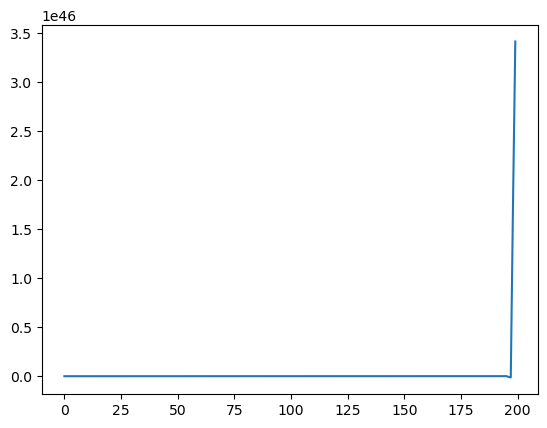

In [333]:
steadies = m.get_steady()
data = steadies["V_ss"]
fig, ax = plt.subplots()
ax.plot(data)
plt.show()

In [317]:
steadies["V_ss"]

array([ 5.47810721e+00,  2.18366196e+00,  3.52232849e+00,  5.61322429e-01,
        3.14434930e+00,  5.32654013e-01,  3.08809929e+00,  5.34641515e-01,
        3.03976810e+00,  5.37131965e-01,  2.99306972e+00,  5.39517380e-01,
        2.94780944e+00,  5.41790735e-01,  2.90392331e+00,  5.43957546e-01,
        2.86135354e+00,  5.46023281e-01,  2.82004555e+00,  5.47993101e-01,
        2.77994770e+00,  5.49871874e-01,  2.74101109e+00,  5.51664196e-01,
        2.70318935e+00,  5.53374407e-01,  2.66643856e+00,  5.55006608e-01,
        2.63071699e+00,  5.56564677e-01,  2.59598506e+00,  5.58052285e-01,
        2.56220514e+00,  5.59472907e-01,  2.52934146e+00,  5.60829835e-01,
        2.49736000e+00,  5.62126189e-01,  2.46622836e+00,  5.63364928e-01,
        2.43591571e+00,  5.64548861e-01,  2.40639265e+00,  5.65680654e-01,
        2.37763116e+00,  5.66762838e-01,  2.34960451e+00,  5.67797822e-01,
        2.32228718e+00,  5.68787892e-01,  2.29565481e+00,  5.69735226e-01,
        2.26968412e+00,  

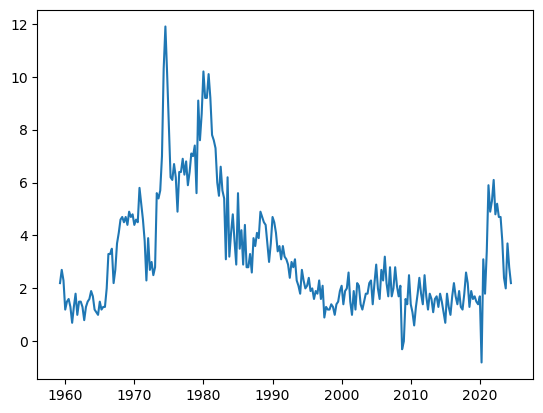

In [2]:
fred = Fred(api_key='fb3e370b05031fcac8fc370f45f58f37')
data = fred.get_series('DPCCRV1Q225SBEA')
fig, ax = plt.subplots()
ax.plot(data)
plt.show()